In [2]:
import cv2
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt

from pytorchyolo import models, detect
from matplotlib import pyplot as plt
import torch
import cv2
from PIL import Image
from tqdm import tqdm
import numpy as np
import random

import imgaug.augmenters as iaa

In [3]:
df = []
for file in os.listdir('ocr/csv'):
    df.append(pd.read_csv(f'ocr/csv/{file}'))

df = pd.concat(df, axis=0)

In [4]:
df = df[~df['label'].isnull()].reset_index(drop=True)
print(df.shape)

(2667, 2)


In [5]:
df.to_csv('temp.csv', index=False)

In [13]:
path_image = '/home/dmk/Documents/LicenceOCR/darknet/data/images'
path_label = '/home/dmk/Documents/LicenceOCR/darknet/data/labels'
list_file_label = os.listdir(path_label)

In [54]:
aug = iaa.Sequential([
    iaa.SomeOf(1, [iaa.Affine(rotate=random.randrange(-25, -10)), iaa.Affine(rotate=random.randrange(10, 25))]),
    iaa.SomeOf(1, [
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True),
        iaa.JpegCompression(compression=(5, 80)),
        iaa.PiecewiseAffine(scale=(0.01, 0.01))              
    ])
])

In [55]:
def split_df(df, ratio: float = 0.9):
    n_train = int(len(df) * ratio)
    return df[:n_train], df[n_train:]
    

def read_coordinate(file_label):
    with open(f"{path_label}/{file_label}.txt", 'r') as file:
        data = file.readlines()
    coordinate = data[0].strip().split(' ')[1:5]
    return [float(value) for value in coordinate]
    
# def crop_image(file_image, n_image_aug: int = 3):
#     image = cv2.imread(f"{path_image}/{file_image}")
#     file_name, extension = os.path.splitext(file_image)
#     height, width, _ = image.shape
#     coordinate = read_coordinate(file_name)
#     x, y, w, h = int(width * coordinate[0]), int(height  * coordinate[1]), int(width * coordinate[2]), int(height * coordinate[3])
#     image = image[int(y - h/2): int(y + h/2):, int(x - w/2): int(x + w/2), :]
#     cv2.imwrite(f'ocr/images/{file_image}', image)


In [56]:
df['is_car'] = df['file_name'].apply(lambda x: 'car' in x)

In [57]:
df_moto = df[df['is_car'] == False].reset_index()
df_car = df[df['is_car'] == True].reset_index()
df_moto_train, df_moto_test = split_df(df_moto)
df_car_train, df_car_test = split_df(df_car)
df_train = pd.concat((df_moto_train, df_car_train), axis=0)
df_val = pd.concat((df_moto_test, df_car_test))

In [58]:
def save_file(df, mode: str = 'train', mode_aug: bool = False,n_image_aug: int = 3):
    with open(f'ocr/{mode}.txt', 'w') as file:
        for idx, row in tqdm(df.iterrows(), total=len(df)):
            file_image = row['file_name']
            label = row['label']
            image = cv2.imread(f"{path_image}/{file_image}")
            file_name, extension = os.path.splitext(file_image)
            height, width, _ = image.shape
            coordinate = read_coordinate(file_name)
            x, y, w, h = int(width * coordinate[0]), int(height  * coordinate[1]), int(width * coordinate[2]), int(height * coordinate[3])
            image = image[int(y - h/2): int(y + h/2):, int(x - w/2): int(x + w/2), :]
            file.write(f"images/{file_name}{extension}" + '\t' + label + '\n')
            cv2.imwrite(f'ocr/images/{file_name}{extension}', image)
            if mode_aug:
                for i in range(n_image_aug):
                    image_aug = aug.augment_image(image)
                    cv2.imwrite(f'ocr/images/{file_name}_aug_{i}{extension}', image_aug)
                    file.write(f"images/{file_name}_aug_{i}{extension}" + '\t' + label + '\n')
                    

In [59]:
save_file(df_train, mode_aug=True)

100%|██████████| 2399/2399 [02:08<00:00, 18.68it/s]


In [60]:
save_file(df_val, mode='val')

100%|██████████| 268/268 [00:00<00:00, 268.17it/s]


In [62]:
image = cv2.imread('darknet/data/images/car_AQUA2_77998_checkin_2020-10-28-8-29mNO_N2GaTr.jpg')
print(image.shape)
height, width, _ = image.shape
x, y, w, h = int(width * 0.503000), int(height * 0.653291), int(width * 0.646000), int(height*0.115570)
print(h)
cv2.imwrite('temp.png', image[int(y - h/2): int(y + h/2),int(x - w/2): int(x + w/2) ])

(644, 400, 3)
74


True

In [1]:
from PIL import Image
import numpy as np

from imgaug import augmenters as iaa
import imgaug as ia

class ImgAugTransform:
  def __init__(self):
    sometimes = lambda aug: iaa.Sometimes(0.3, aug)

    self.aug = iaa.Sequential(iaa.SomeOf((1, 5), 
        [
        # blur

        sometimes(iaa.OneOf([iaa.GaussianBlur(sigma=(0, 1.0)),
                            iaa.MotionBlur(k=3)])),
        
        # color
        sometimes(iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)),
        sometimes(iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6), per_channel=True)),
        sometimes(iaa.Invert(0.25, per_channel=0.5)),
        sometimes(iaa.Solarize(0.5, threshold=(32, 128))),
        sometimes(iaa.Dropout2d(p=0.5)),
        sometimes(iaa.Multiply((0.5, 1.5), per_channel=0.5)),
        sometimes(iaa.Add((-40, 40), per_channel=0.5)),

        sometimes(iaa.JpegCompression(compression=(5, 80))),
        
        # distort
        sometimes(iaa.Crop(percent=(0.01, 0.05), sample_independently=True)),
        sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.01))),
        sometimes(iaa.Affine(scale=(0.7, 1.3), translate_percent=(-0.1, 0.1), 
                           rotate=(-40, 40),
                            order=[0, 1], cval=(0, 255), 
                            mode=ia.ALL)),
        sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.01))),
        sometimes(iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                            iaa.CoarseDropout(p=(0, 0.1), size_percent=(0.02, 0.25))])),

    ],
        random_order=True),
    random_order=True
    )
      
  def __call__(self, img):
    img = np.array(img)
    img = self.aug.augment_image(img)
    img = Image.fromarray(img)
    return img


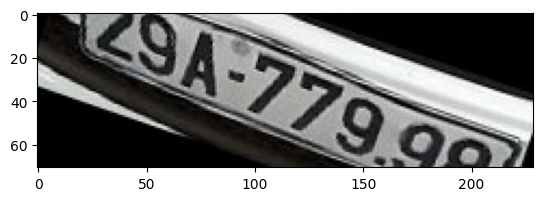

In [53]:
# aug = iaa.SomeOf(2, [
#     iaa.SomeOf(1, [iaa.Affine(rotate=-45), iaa.Affine(rotate=45)]),
#     iaa.LinearContrast((0.75, 1.5)),
#     iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
# ])

import imgaug.augmenters as iaa
aug = iaa.Sequential([
    iaa.SomeOf(1, [iaa.Affine(rotate=random.randrange(-25, -10)), iaa.Affine(rotate=random.randrange(10, 25))]),
    iaa.SomeOf(1, [
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True),
        iaa.JpegCompression(compression=(5, 80)),
        iaa.PiecewiseAffine(scale=(0.01, 0.01))              
    ])
])

img = cv2.imread('ocr/images/car_AQUA2_77998_checkin_2020-10-28-8-29mNO_N2GaTr.jpg')
img = np.array(img)
img = aug.augment_image(img)
img = Image.fromarray(img)
plt.imshow(img)

In [ ]:
transform = ImgAugTransform()

In [1]:
torch.__version__

NameError: name 'torch' is not defined

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model = models.load_model('darknet/cfg/yolov3-tiny.cfg', 'darknet/backup/yolov3-tiny_2000.weights').to(device)


183 80 276 172


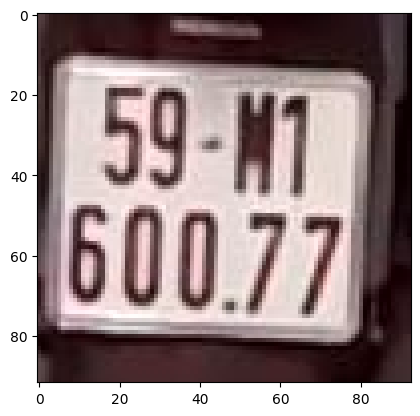

In [20]:
image = cv2.imread('darknet/data/images/moto_0153_02530_b.jpg')
boxes= detect.detect_image(model, image)
x,y,x1,y1 = int(boxes[0][0]), int(boxes[0][1]), int(boxes[0][2]), int(boxes[0][3])
numpy_image = image[y:y1, x:x1,:]
print(x,y, x1, y1)
imgage_ocr = Image.fromarray(np.uint8(numpy_image)).convert('RGB')
plt.imshow(imgage_ocr)

In [10]:
boxes[0][:5]

array([183.50214  ,  80.486206 , 276.14188  , 172.43459  ,   0.9931244],
      dtype=float32)

In [4]:
with open('ocr/train.txt', 'r') as file:
    data = file.readlines()

In [21]:
from collections import Counter 
import itertools
with open('ocr/train.txt', 'r') as file:
    data = file.readlines()
data = [value.split('\t')[1].strip() for value in data]
data = list(set(data))
data = [list(value) for value in data]
data = list(itertools.chain(*data))
result = dict(Counter(data))

In [22]:
sum_value = sum(1/value for value in result.values())
for key in result.keys():
    result[key] = (1 / result[key]) / sum_value

In [23]:
result

{'3': 0.002097928265571808,
 '0': 0.0020451132882567135,
 'A': 0.012236451892079916,
 '-': 0.0017345860036815542,
 '6': 0.0025721301690475817,
 '8': 0.0029690477179767512,
 '.': 0.001972024276606271,
 '2': 0.0021727429436902675,
 '9': 0.001563910161608075,
 '5': 0.0014463461929807616,
 'P': 0.02543053914962696,
 '1': 0.0015375983187208727,
 '4': 0.0024555096576046177,
 'K': 0.051307228108896485,
 '7': 0.0027486015058337406,
 'M': 0.06222365962142766,
 'G': 0.03523508436394097,
 'F': 0.012770794769463318,
 'S': 0.026111714305420534,
 'U': 0.04794281970831312,
 'D': 0.04364943286876269,
 'E': 0.022155393956114395,
 'B': 0.02543053914962696,
 'H': 0.02543053914962696,
 'N': 0.04794281970831312,
 'C': 0.021824716434381344,
 'L': 0.02733188787109439,
 'X': 0.055179471739756604,
 'T': 0.04061822225287639,
 'V': 0.051307228108896485,
 'Z': 0.08601505888844412,
 'Y': 0.1083152593410037,
 'R': 0.14622560011035501}

In [24]:
sum(result.values())

1.0